<a href="https://colab.research.google.com/github/wlgnsthd/UAM_UOU/blob/main/Model_Maker(TF2%2CRoblflow).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이센스

##### *Copyright 2021 Google LLC*
*Licensed under the Apache License, Version 2.0 (the "License")*

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## 딥러닝 준비


Tensorflow lite 


필수 패키지 설치

In [ ]:
!pip install -q tflite-model-maker
!pip install -q pycocotools
!pip install pandas

필수 패키지 import


In [ ]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

Dataset(.csv파일로 제공:80%training학습, 10%validation검증, 10%testing테스트 image- n개의 classes) 개인 dataset만들기
-> Roboflow로 부터 라벨링된 Pascal VOC파일 불러와야함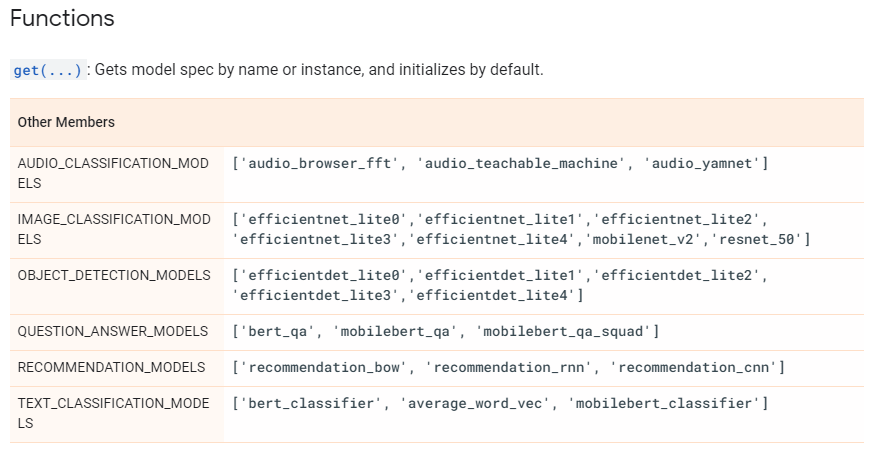

Object detection model 학습시키기(model archiecture : EfficientDet-lite0)

In [ ]:
spec = model_spec.get('efficientdet_lite0')

Pascal VOC파일 불러와서 label한 것들을 Training, Validation, Testing으로 분류한다. 

In [ ]:
!curl -L "https://app.roboflow.com/ds/Z6iRm48Ryc?key=UzqrYIZZJA" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
os.mkdir('./train/images')
os.mkdir('./train/annotation')
os.mkdir('./test/images')
os.mkdir('./test/annotation')
os.mkdir('./valid/images')
os.mkdir('./valid/annotation')

In [ ]:
import glob, shutil

files = glob.iglob(os.path.join('./train', "*.jpg"))
for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, './train/images')

files = glob.iglob(os.path.join('./train', "*.xml"))
for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, './train/annotation')

files = glob.iglob(os.path.join('./test', "*.jpg"))
for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, './test/images')

files = glob.iglob(os.path.join('./test', "*.xml"))
for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, './test/annotation')

files = glob.iglob(os.path.join('./valid', "*.jpg"))
for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, './valid/images')

files = glob.iglob(os.path.join('./valid', "*.xml"))
for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, './valid/annotation')

train_data = object_detector.DataLoader.from_pascal_voc('./train/images', './train/annotation', label_map={1: "balloon"})
validation_data = object_detector.DataLoader.from_pascal_voc('./valid/images', './valid/annotation', label_map={1: "balloon"})
test_data = object_detector.DataLoader.from_pascal_voc('./test/images', './test/annotation', label_map={1: "balloon"})

## 딥러닝 시작

Training dataset로 훈련시킨다. epochs =50기본 (50번 반복)
validation accuracy와 overfitting 피하도록 유도해야함.
batch_size =8 (한번 시행시 데이터 크기)
 train_whole_model=True 정확성을 높이기 위해 해야함(시간은 오래걸림)

In [ ]:
model = object_detector.create(train_data, model_spec=spec, epochs= 50,batch_size=8, train_whole_model=False, validation_data=validation_data)

test data로 모델을 평가하자

In [ ]:
model.evaluate(test_data)

Tensorflow Lite 모델로 내보내자

In [ ]:
model.export(export_dir='.')

## Edge TPU로 변환 준비

In [ ]:
%env TFLITE_FILE=model.tflite

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

In [ ]:
! edgetpu_compiler $TFLITE_FILE

3초 정도 기다리기

In [ ]:
import time
time.sleep(3)

## 최종 모델 다운로드

In [ ]:
import os
from google.colab import files

name = os.path.splitext(os.environ['TFLITE_FILE'])[0]
files.download(str(name + '_edgetpu.tflite'))